In [1]:
import torch
from torchvision import datasets, transforms
from utility.HebbianNetwork import HebbianNetwork
import matplotlib.pyplot as plt
import numpy as np
import pickle

# set seed for reproducibility
torch.manual_seed(42)

In [2]:
# Define the transformation to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the MNIST training dataset
trn_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=128, shuffle=True)

# Split the training dataset into training and validation datasets
train_size = int(0.8 * len(trn_dataset))
val_size = len(trn_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trn_dataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True)


# Download and load the MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


In [3]:
# Print the number of samples in the training and test datasets
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
model = HebbianNetwork([784, 500, 10], device=device, init="uni")
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.000001)

Number of training samples: 48000
Number of test samples: 10000


In [4]:
params = list(model.parameters())
tot_numel = 0
for p in params:
    tot_numel += p.numel()

print(f"Total number of parameters to train: {tot_numel}")

print("Total number of weights: {}".format(784*500 + 500*10))


Total number of parameters to train: 5684
Total number of weights: 397000


In [5]:
train_loss, val_loss, test_loss, train_accuracy, val_accuracy, test_accuracy = model.train_loop(
    optimizer, loss_fn, train_loader, val_loader, test_loader, epochs=50
)

print(f"Validation loss: {val_loss[-10:]}")
print(f"Validation accuracy: {val_accuracy[-10:]}")
print(f"Test loss: {np.mean(test_loss)}")
print(f"Test accuracy: {np.mean(test_accuracy)}")

plt.plot(train_loss, label="Train")
plt.plot(val_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# save the plot
plt.show()

# clear the plot
plt.clf()

plt.plot(train_accuracy, label="Train")
plt.plot(val_accuracy, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training:   8%|▊         | 4/50 [00:53<10:15, 13.39s/epoch, Train Loss=1.94, Val Loss=1.67, Train Accuracy=0.195, Val Accuracy=0.284]

Training weights: 100%|██████████| 1/1 [00:08<00:00,  8.61s/epoch, Train Loss=1.34]


Test loss: 1.528238391574425
Test accuracy: 0.7052017405063291


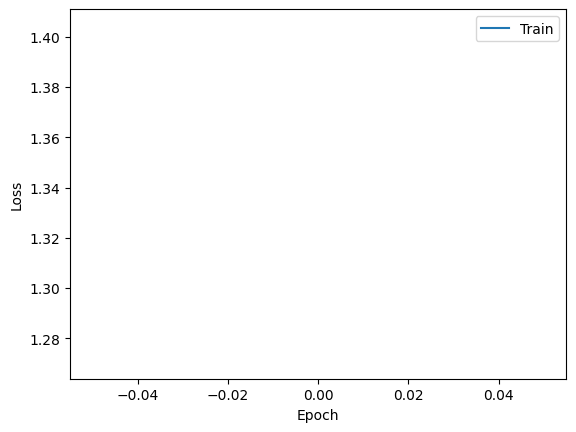

In [ ]:
train_loss, test_loss, test_accuracy = model.train_weights(loss_fn, trn_loader, test_loader, epochs=1)

print(f"Test loss: {np.mean(test_loss)}")
print(f"Test accuracy: {np.mean(test_accuracy)}")

plt.plot(train_loss, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()